# SHC / TC / TD Prediction - ThermoProfiler
*Predicting Petrophysical Properties from Well Logs*

- Upload your well log data 
- Select **rock type, model, and target variable**
- Run predictions using pre-trained models


In [59]:
# MAKE SURE OF CORRECT VERSIONS
#pip install scikit-learn==1.2.1
#pip install numpy==1.25.2

import pandas as pd
import numpy as np
from joblib import load
import sys
import os
# Debug: Print current directory and sys.path
print("Current directory:", os.getcwd())
print("Python path:", sys.path)

# Add thermoprofiler directory to Python path
sys.path.append('../../../../../thermoprofiler')

# Debug: List files in thermoprofiler directory
try:
    print("Files in ../thermoprofiler:", os.listdir('../thermoprofiler'))
except FileNotFoundError:
    print("Error: ../thermoprofiler directory not found")

# Import config and model_selector
try:
    import thermoprofiler.config as config
    import thermoprofiler.model_selector as model_selector
    print("Imported config and model_selector successfully")
    # Debug: Check if get_model_paths exists
    print("get_model_paths in model_selector:", hasattr(model_selector, 'get_model_paths'))
except Exception as e:
    print("Import error:", str(e))

Current directory: c:\Users\dergun\Documents\thermoprofiler\notebook_tutorial\01- simple example\Linear
Python path: ['c:\\Users\\dergun\\miniforge3\\envs\\heatflow_work\\python311.zip', 'c:\\Users\\dergun\\miniforge3\\envs\\heatflow_work\\DLLs', 'c:\\Users\\dergun\\miniforge3\\envs\\heatflow_work\\Lib', 'c:\\Users\\dergun\\miniforge3\\envs\\heatflow_work', '', 'c:\\Users\\dergun\\miniforge3\\envs\\heatflow_work\\Lib\\site-packages', '__editable__.gempy-2025.2.1.dev0+g9f9e4d12a.d20250829.finder.__path_hook__', 'c:\\Users\\dergun\\miniforge3\\envs\\heatflow_work\\Lib\\site-packages\\win32', 'c:\\Users\\dergun\\miniforge3\\envs\\heatflow_work\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\dergun\\miniforge3\\envs\\heatflow_work\\Lib\\site-packages\\Pythonwin', '../thermoprofiler', '../../thermoprofiler', '../../../thermoprofiler', '../../../../thermoprofiler', '../../../../thermoprofiler', '../../../../thermoprofiler', '../thermoprofiler', '../../../thermoprofiler', '../../../thermoprofil

### STEP 1 -  LOAD DATA

In [51]:
df = pd.read_csv(
    r"C:\Users\dergun\Documents\SHC-TC-TD-Prediction-using-petrophysical-well-logs\notebook\Example_well_input (1).txt",
    encoding="utf-16",   
    sep="\t", 
    header=0
)

# Drop first row (often metadata) and reset index
df = df.drop(0).reset_index(drop=True)

# Clean column names
df.columns = df.columns.str.strip()
print("Columns:", df.columns.tolist())
df.head()



Columns: ['Depth', 'Stratigraphy', 'Temp', 'GR', 'CAL', 'PHIN', 'RHOB', 'VSH', 'Lithology', 'Rock_type']


,Depth,Stratigraphy,Temp,GR,CAL,PHIN,RHOB,VSH,Lithology,Rock_type
0,0.00,Quaternary-Saale,-999.25,8.59859,-999,-999,-999,-999.25,S,3
1,0.25,Quaternary-Saale,-999.25,8.59859,-999,-999,-999,0.065429,S,3
2,0.50,Quaternary-Saale,-999.25,7.65106,-999,-999,-999,0.0482012,S,3
3,0.75,Quaternary-Saale,-999.25,7.70233,-999,-999,-999,0.0491333,S,3
4,1.00,Quaternary-Saale,-999.25,9.43716,-999,-999,-999,0.0806757,S,3


In [52]:
df = df.drop(0).reset_index(drop=True)
df.columns = df.columns.str.strip()

# Display DataFrame info
print("Columns:", df.columns.tolist())
df.head()

# Get log columns (exclude Rock_type)
log_columns = [col for col in df.columns if col in config.VALID_LOG_COLUMNS]
print("Log columns:", log_columns)

# Test get_model_paths for each unique Rock_type
unique_rock_types = df['Rock_type'].unique()
print("\nTesting get_model_paths for unique Rock_type values:")
for rock_type in unique_rock_types:
    print(f"\nRock_type: {rock_type}")
    try:
        paths = model_selector.get_model_paths(
            rock_type_id=int(rock_type),
            model_type="XGBBoost",
            log_columns=log_columns
        )
        print("Model paths:", paths)
    except Exception as e:
        print("Error:", str(e))

Columns: ['Depth', 'Stratigraphy', 'Temp', 'GR', 'CAL', 'PHIN', 'RHOB', 'VSH', 'Lithology', 'Rock_type']
Log columns: ['PHIN', 'RHOB', 'VSH']

Testing get_model_paths for unique Rock_type values:

Rock_type:          3
Error: module 'thermoprofiler.model_selector' has no attribute 'get_model_paths'

Rock_type:     nodata
Error: module 'thermoprofiler.model_selector' has no attribute 'get_model_paths'


### STEP 2 - STANDARIZE COLUMNS AND CLEAN COLUMS


In [53]:
df = df.rename(columns=lambda c: c.strip())  # remove leading/trailing spaces

TARGET_COLS = ["RHOB", "PHIN", "VSH", "Vp"]

for col in TARGET_COLS:
    if col in df.columns:
        s = df[col].astype(str).str.strip()
        # normalize decimal commas
        s = s.str.replace(",", ".", regex=False)
        s = pd.to_numeric(s, errors="coerce")
        # Null-out sentinel values (e.g., -999.25)
        s = s.where(~(s <= -9), np.nan)
        df[col] = s



### STEP 4 - ENSURE CORRECT UNITS FOR PHIN AND VSH ( % -> FRACTIONS)

In [54]:
# If values look like percentages (> 1), divide by 100
if "PHIN" in df.columns:
    if df["PHIN"].dropna().max() > 1.5: 
        df["PHIN"] = df["PHIN"] / 100.0

if "VSH" in df.columns:
    if df["VSH"].dropna().max() > 1.5:
        df["VSH"] = df["VSH"] / 100.0



### STEP 5 - ASSIGN MODEL NUMBER PER INTERVALL
Assigns a model number to each row in the dataset depending on which combination of logs is available in the row.
| Model Number | Logs Included                  |
| -- | ------------------------------ |
| 1  | \['RHOB']                      |
| 2  | \['PHIN']                      |
| 3  | \['VSH']                       |
| 4  | \['Vp']                        |
| 5  | \['RHOB', 'PHIN']              |
| 6  | \['RHOB', 'VSH']               |
| 7  | \['RHOB', 'Vp']                |
| 8  | \['PHIN', 'VSH']               |
| 9  | \['PHIN', 'Vp']                |
| 10 | \['VSH', 'Vp']                 |
| 11 | \['RHOB', 'PHIN', 'VSH']       |
| 12 | \['RHOB', 'PHIN', 'Vp']        |
| 13 | \['RHOB', 'VSH', 'Vp']         |
| 14 | \['PHIN', 'VSH', 'Vp']         |
| 15 | \['RHOB', 'PHIN', 'VSH', 'Vp'] |


In [55]:
log_combinations = {
    1: ['RHOB'],
    2: ['PHIN'],
    3: ['VSH'],
    4: ['Vp'],
    5: ['RHOB', 'PHIN'],
    6: ['RHOB', 'VSH'],
    7: ['RHOB', 'Vp'],
    8: ['PHIN', 'VSH'],
    9: ['PHIN', 'Vp'],
    10: ['VSH', 'Vp'],
    11: ['RHOB', 'PHIN', 'VSH'],
    12: ['RHOB', 'PHIN', 'Vp'],
    13: ['RHOB', 'VSH', 'Vp'],
    14: ['PHIN', 'VSH', 'Vp'],
    15: ['RHOB', 'PHIN', 'VSH', 'Vp']
}
desired_order = ['RHOB', 'PHIN', 'VSH', 'Vp']  # canonical ordering

# --- 4) Row-wise model number assignment -------------------------------------
def row_model_number(row):
    # which of the canonical logs are present (non-NaN) in THIS row, in canonical order
    available = [c for c in desired_order if c in row.index and pd.notna(row[c])]
    # match against combinations (order matters)
    for num, combo in log_combinations.items():
        if available == combo:
            return num
    return np.nan  # no valid mapping

df["model_number"] = df.apply(row_model_number, axis=1)

# --- 4b) Drop rows without a valid model_number ---
df = df.dropna(subset=["model_number"]).copy()
df["model_number"] = df["model_number"].astype(int)  # make it clean integers
df.tail()   


,Depth,Stratigraphy,Temp,GR,CAL,PHIN,RHOB,VSH,Lithology,Rock_type,model_number
3139,785.00,Postera,-999.25,59.8,47,NaN,2.628,NaN,Mrlst,3,1
3140,785.25,Postera,-999.25,58.7,47,NaN,2.544,NaN,Mrlst,3,1
3141,785.50,Postera,-999.25,53.2,47,NaN,2.462,NaN,Mrlst,3,1
3142,785.75,Postera,-999.25,51.8,47,NaN,2.480,NaN,Mrlst,3,1
3143,786.00,Postera,-999.25,49.7,47,NaN,2.518,NaN,Mrlst,3,1


### STEP 6 - PREDICT THERMAL PROPERTIES 
In this step, thermal properties (e.g., thermal conductivity (TC) and heat capacity (SHC)) are predicted. 
Rock type options:

- Carbonates
-  Evaporites
-   Clastics

Model options:

-   Linear Regression
-   AdaBoost
-   XGBoost
-   Random Forest (RF)

Target properties:
-   Thermal Difussivity (TD)
-   Thermal Conductivity (TC)
-   Heat Capacity (SHC)

In [56]:


# --- 5) Predict per model_number group ---------------------------------------
predictions = []

for model_num, group in df.groupby("model_number"):
    model_path = fr"C:\Users\dergun\Documents\SHC-TC-TD-Prediction-using-petrophysical-well-logs\models\Carbonates\RF\TC\{model_num}.joblib" # CHANGE  here
    model = load(model_path)

    # Features in the correct order
    features = log_combinations[model_num]
    X = group[features]

    # Predict
    y_pred = model.predict(X)

    # Store in df (align by index)
    df.loc[group.index, "Prediction"] = y_pred

print(df[["Depth", "model_number", "Prediction"]].head(300))


          Depth  model_number  Prediction
0          0.25             3    2.862355
1          0.50             3    2.862355
2          0.75             3    2.862355
3          1.00             3    2.782756
4          1.25             3    2.782756
..          ...           ...         ...
295       74.00             3    2.424172
296       74.25             3    2.525251
297       74.50             3    2.623310
298       74.75             3    2.623310
299       75.00             3    2.623310

[300 rows x 3 columns]


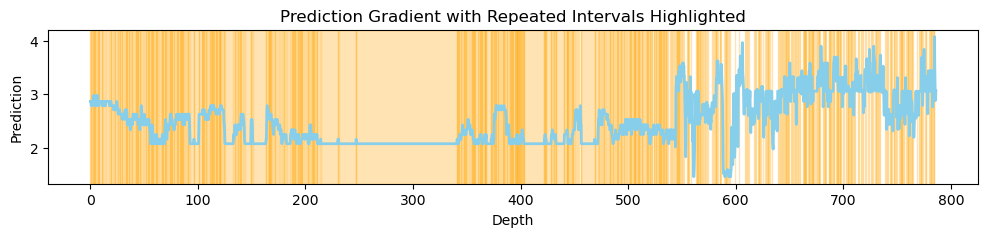

In [57]:
import matplotlib.pyplot as plt

pred_col = "Prediction"  # your prediction column

# Ensure numeric
df[pred_col] = df[pred_col].astype(float)
df['Depth'] = df['Depth'].astype(float)

# --- Gradient plot ---
plt.figure(figsize=(12, 2))
plt.plot(df['Depth'], df[pred_col], color='skyblue', linewidth=2)
plt.ylabel(pred_col)
plt.xlabel('Depth')
plt.title('Prediction Gradient with Repeated Intervals Highlighted')

# --- Find repeated intervals ---
repeats = []
current_val = df[pred_col].iloc[0]
start_idx = 0

for i in range(1, len(df)):
    if df[pred_col].iloc[i] != current_val:
        end_idx = i - 1
        if end_idx != start_idx:
            repeats.append((start_idx, end_idx, current_val))
        current_val = df[pred_col].iloc[i]
        start_idx = i

# Capture last run
if start_idx != len(df) - 1:
    repeats.append((start_idx, len(df)-1, current_val))

# --- Highlight repeated intervals ---
for start, end, val in repeats:
    plt.axvspan(df['Depth'].iloc[start], df['Depth'].iloc[end], color='orange', alpha=0.3)

plt.show()


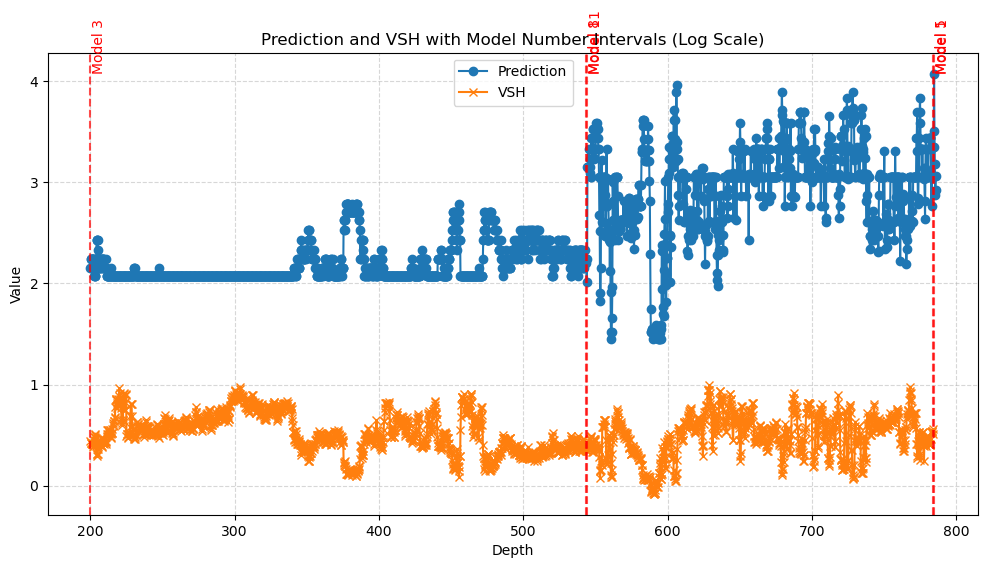

In [58]:
import matplotlib.pyplot as plt

# Depth slice
df_slice = df[(df['Depth'] >= 200) & (df['Depth'] <= 1000)]

# Plot Prediction and VSH vs Depth
plt.figure(figsize=(12, 6))
plt.plot(df_slice['Depth'], df_slice['Prediction'], label='Prediction', marker='o')
plt.plot(df_slice['Depth'], df_slice['VSH'], label='VSH', marker='x')

# Find depths where model_number changes
model_changes = df_slice['model_number'].ne(df_slice['model_number'].shift())
change_depths = df_slice.loc[model_changes, 'Depth'].values
model_numbers = df_slice.loc[model_changes, 'model_number'].values

# Add vertical lines and labels for model_number changes
for i, depth in enumerate(change_depths):
    plt.axvline(x=depth, color='red', linestyle='--', alpha=0.7)
    plt.text(depth + 1, max(df_slice['Prediction'].max(), df_slice['VSH'].max()), 
             f'Model {int(model_numbers[i])}', rotation=90, verticalalignment='bottom', color='red')

plt.xlabel('Depth')
plt.ylabel('Value')
#plt.yscale('log')  # log scale
plt.title('Prediction and VSH with Model Number Intervals (Log Scale)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

